# PSG for Lung
+ We select the most uncorrelated features to extract the best clusters.
+ Three sets of features:
    - first set : domain expert
    - second set : most uncorrelated
    - third set: P set
- convert each feature into a PSG
- Apply SNF
- Implement spectral clustering
- run survival analysis for different options
- content

    - [Function](#Functions)
    - [Reading the dataset (Lung)](#Reading-the-dataset-(Lung))
    - [Direct implementation](#Direct-Implementation)
    - [SNF + Spectral clustering Analysis](#SNF-+-Spectral-clustering-Analysis)
    - [Correlating with Cancer types](#Correlating-with-Cancer-types)
    - [Cancer type-based analysis](#Cancer-type-based-analysis)
    
        - [NSCLC survival analysis](#NSCLC-survival-analysis)
        - [NSCLC_surgery survival analysis](#NSCLC_surgery-survival-analysis)
        - [NSCLC survival analysis](#SCLC-survival-analysis)
    - [Correlating with clusters](#Correlating-with-clusters)

In [1]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
All = [  'LU_DVH_23',
         'LU_DVH_24',
         'LU_DVH_25',
         'LU_DVH_26',
         'LU_DVH_27',
         'LU_DVH_28',
         'LungEsophagitisTotal',
         'LungEsophagitisWithGrade',
         'LungPneumonitisTotal',
         'LungPneumonitisWithGrade',
         'Lung_Contra_Already_Subtracted_DMean',
         'Lung_Contra_Already_Subtracted_V20Gy',
         'Lung_Contra_Already_Subtracted_V5Gy',
         'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_DMean',
         'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V20Gy',
         'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V5Gy',
         'Lung_Ipsi_Already_Subtracted_DMean',
         'Lung_Ipsi_Already_Subtracted_V20Gy',
         'Lung_Ipsi_Already_Subtracted_V5Gy',
         'NumberOfNotesWithToxicityInitialized',
         'TotalNumberOfNotes',
         'cancer_type']

# Our selection

In [3]:
OS = ['LU_DVH_27', 
      'LungPneumonitisTotal',
      'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_DMean', 
      'Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V20Gy',
      'Lung_Ipsi_Already_Subtracted_V20Gy']

In [4]:
distance = ['euclidean','minkowski','cityblock','seuclidean','sqeuclidean','cosine','correlation','hamming','jensenshannon','chebyshev','canberra','braycurtis','mahalanobis','yule','matching','dice','kulczynski1','rogerstanimoto','russellrao','sokalmichener']
no_scale = ['vha_id', 'center_name', 'cancer_type']
Prostate_QMs = ['QualityMeasure1','QualityMeasure10','QualityMeasure11','QualityMeasure12','QualityMeasure13','QualityMeasure14','QualityMeasure15','QualityMeasure15_color','QualityMeasure16','QualityMeasure17A','QualityMeasure17B','QualityMeasure18','QualityMeasure19','QualityMeasure2','QualityMeasure24','QualityMeasure3','QualityMeasure4','QualityMeasure5','QualityMeasure6','QualityMeasure7','QualityMeasure8','QualityMeasure9']
Lung_QMs = ['QualityMeasure1','QualityMeasure10','QualityMeasure11','QualityMeasure12','QualityMeasure13','QualityMeasure14','QualityMeasure15','QualityMeasure15Chemo','QualityMeasure15RT','QualityMeasure15Surgery','QualityMeasure16','QualityMeasure17','QualityMeasure18','QualityMeasure19','QualityMeasure19_color','QualityMeasure2','QualityMeasure20','QualityMeasure21A','QualityMeasure21B','QualityMeasure22','QualityMeasure23','QualityMeasure24','QualityMeasure27','QualityMeasure3','QualityMeasure4','QualityMeasure5','QualityMeasure6','QualityMeasure7','QualityMeasure8A','QualityMeasure8B','QualityMeasure9']
dist = distance[0]

def extract_features(df):
    return [i for i in df if i not in no_scale]

def exclude_QM(df, t):
    if t=='Lung':
        return [i for i in df if i not in Lung_QMs]
    else:
        return [i for i in df if i not in Prostate_QMs]
    
    

### Functions

In [5]:
def scaling(df):
    features_to_scale = extract_features(df)
    scaler = StandardScaler()
    scaler.fit(df[features_to_scale])
    scaled_features = scaler.transform(df[features_to_scale])
    df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)
    df_scaled[no_scale] = df[no_scale]
    return df_scaled

#Dropping columns with missed values of more than 80%

def dropping_cols(df, p=80):
    nan_counts = df.isna().sum()    
    nan_percentages = nan_counts / len(df) * 100 
    cols_to_drop = nan_percentages[nan_percentages > p].index.tolist()
    df = df.drop(cols_to_drop, axis=1)
    return df    


In [6]:
def histo(data, disease):
    T = data['Days']
    E = data['state']

    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Days-cluster for {disease} Patients')
    plt.hist(T, bins = 30)
    plt.show()

    kmf = KaplanMeierFitter()
    kmf.fit(durations = T, event_observed = E)
    kmf.plot()

    kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

In [7]:
def SNF(DB, dist):
    affinity_networks = snf.make_affinity(DB, metric=dist, K=20, mu=0.5)
    fused_network = snf.snf(affinity_networks, K=20)
    best, second = snf.get_n_clusters(fused_network)
    print(best, second)
    return fused_network, best, second


In [8]:
def groups_details(groups, labels):        
    for i in range(len(groups)):
        print(f'Number of patients in cluser {i} = {len(groups[i])}')


    Ts = [groups[i]['Days'] for i in range(len(groups))]
    Es = [groups[i]['state'] for i in range(len(groups))]

    kmf = KaplanMeierFitter()
    for i in range(len(groups)):
        kmf.fit(durations = Ts[i], event_observed = Es[i], label=labels[i])
        kmf.plot()

    #kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

    import itertools

    # Generate all combinations of length 2 from a list of integers
    numbers = [i for i in range(len(groups))]
    combinations = itertools.combinations(numbers, 2)

    # Perform the log-rank test
    for i, j in combinations:
        results = logrank_test(groups[i]['Days'], groups[j]['Days'], event_observed_A=groups[i]['state'], event_observed_B=groups[j]['state'])
        print(f'P-value ({i},{j}) = ', results.p_value)

In [9]:
def data_impute(df):
#     from sklearn.impute import KNNImputer
#     imputer = KNNImputer(n_neighbors=10)
#     return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df.fillna(df.mode().iloc[0])

In [10]:
from sklearn.decomposition import PCA
def PCA_model(X, n = 2):
#     print("PCA model")
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

### Reading the dataset (Lung)
- reading numerical dataset

In [11]:
# Preprocessing numerical dataset
survival = pd.read_csv('data/survival.csv')

n_lung = pd.read_csv('data/Lung/numerical.csv', index_col=0)
n_lung = data_impute(n_lung)
scaled_lung = scaling(n_lung)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung = dropping_cols(scaled_lung)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung.dropna(thresh=len(scaled_lung.columns) * 0.2)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung = scaled_lung.drop_duplicates()
print('scaled lung shape is ', scaled_lung.shape)

# scaled_lung = remove_correlated(scaled_lung)
# print('scaled lung shape is ', scaled_lung.shape)
OS_Lung = scaled_lung[OS+['vha_id', 'cancer_type']]
OS_Lung

scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)


,LU_DVH_27,LungPneumonitisTotal,Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_DMean,Lung_Ipsi + Lung_Contra - Lung_Subtraction_Structure ((Lung_Ipsi + Lung_Contra) - Lung_Subtraction_Structure)_V20Gy,Lung_Ipsi_Already_Subtracted_V20Gy,vha_id,cancer_type
0,-1.359905,-0.235991,-1.429881,-1.424251,-0.353586,506-NSCLC-01,NSCLC
1,0.355242,-0.235991,0.387137,0.633562,-0.353586,506-NSCLC-02,NSCLC
2,0.521209,-0.235991,0.717615,0.801847,-0.353586,506-NSCLC-03,NSCLC
3,0.326804,-0.235991,0.394201,0.168811,-0.353586,506-NSCLC-04,NSCLC
4,1.156942,-0.235991,1.172207,1.083809,-0.353586,506-NSCLC-05,NSCLC
...,...,...,...,...,...,...,...
768,0.184529,-0.235991,-0.011409,0.039443,-0.353586,632-NSCLC-06,NSCLC
769,1.103080,-0.235991,0.687467,0.592658,-0.353586,667-NSCLC-08,NSCLC
770,1.120188,-0.235991,0.723888,0.547701,-0.353586,671-NSCLC-08,NSCLC
771,0.128039,-0.235991,0.053273,0.181016,-0.353586,671-SCLC-06,SCLC


- reading and processing categorical dataset

# SNF + Spectral clustering Analysis
- All Features to PSG
- SNF
- Spectral clustering
- survival analysis 
    - cancer types
    - clusters 

In [12]:
#                                     1- Calculate the similarity matrix
nc = 4

lung_db = []
All_in_one = OS_Lung[OS]
for d in All_in_one:
    distances = pdist(All_in_one[d].to_numpy().reshape(-1, 1), metric='euclidean')
    similarity_matrix = 1 / (1 + squareform(distances))
    lung_db.append(similarity_matrix)

    
#                                     2- Fusing to SNF
fused_network, best, second = SNF(lung_db, dist)

#                                     3-  Clustering
lung_labels = spectral_clustering(fused_network, n_clusters= nc)


lung_All     = {'vha_id': OS_Lung['vha_id']    , 'cluster': list(lung_labels), 'cancer_type': OS_Lung['cancer_type'] }
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival, on='vha_id')
print(Lung_survival.head())

2 3
         vha_id  cluster cancer_type  state  firstVisit   lastVisit  Days
0  506-NSCLC-01        1       NSCLC      0  11/18/2009    5/5/2010   168
1  506-NSCLC-02        0       NSCLC      0  11/10/2009    5/9/2010   180
2  506-NSCLC-03        2       NSCLC      0   12/9/2009   8/28/2010   262
3  506-NSCLC-04        0       NSCLC      0  11/18/2009  11/21/2010   368
4  506-NSCLC-05        2       NSCLC      1  12/17/2009   1/15/2011   394


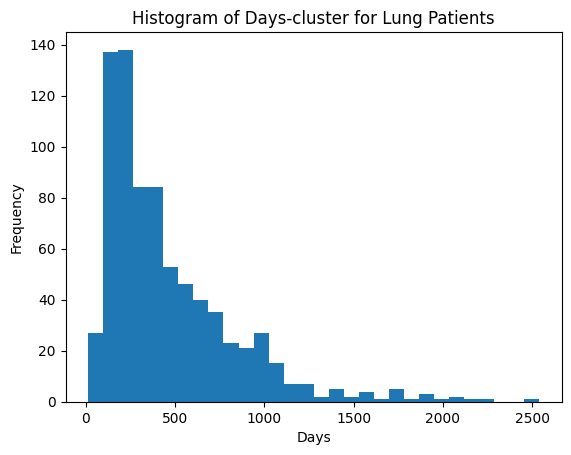

795.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   738.0                   885.0


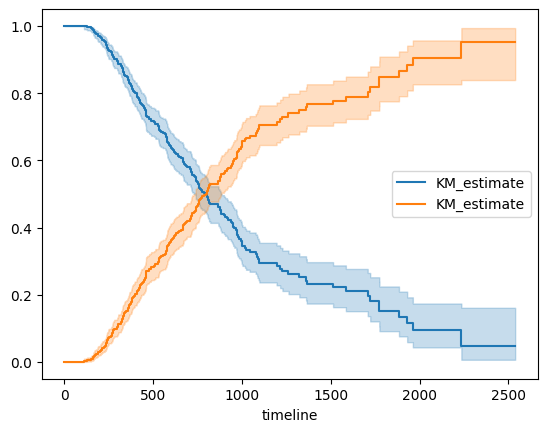

In [13]:
histo(Lung_survival, 'Lung')

# Correlating with Cancer types

In [14]:
Lung_survival

,vha_id,cluster,cancer_type,state,firstVisit,lastVisit,Days
0,506-NSCLC-01,1,NSCLC,0,11/18/2009,5/5/2010,168
1,506-NSCLC-02,0,NSCLC,0,11/10/2009,5/9/2010,180
2,506-NSCLC-03,2,NSCLC,0,12/9/2009,8/28/2010,262
3,506-NSCLC-04,0,NSCLC,0,11/18/2009,11/21/2010,368
4,506-NSCLC-05,2,NSCLC,1,12/17/2009,1/15/2011,394
...,...,...,...,...,...,...,...
768,632-NSCLC-06,0,NSCLC,1,12/9/2009,6/20/2010,193
769,667-NSCLC-08,2,NSCLC,0,11/9/2009,4/15/2010,157
770,671-NSCLC-08,2,NSCLC,0,11/22/2009,3/22/2010,120
771,671-SCLC-06,0,SCLC,0,11/30/2009,6/3/2010,185


# Survival analysis by cancer type

Number of patients in cluser 0 = 547
Number of patients in cluser 1 = 65
Number of patients in cluser 2 = 161
716.0
     SCLC_lower_0.95  SCLC_upper_0.95
0.5            590.0            970.0
P-value (0,1) =  0.0007351651191957134
P-value (0,2) =  0.8610346077055308
P-value (1,2) =  0.0008006640525357157


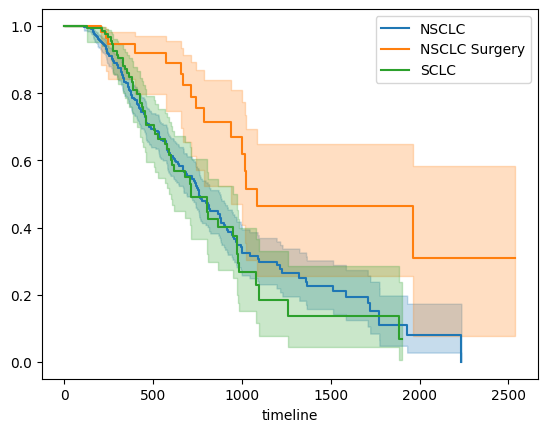

In [15]:
groups1 = dict(tuple(Lung_survival.groupby('cancer_type')))
groups2 = [groups1[i] for i in groups1]
groups_details(groups2, ['NSCLC', 'NSCLC Surgery', 'SCLC'])

# Survival analysis by clusters

Number of patients in cluser 0 = 300
Number of patients in cluser 1 = 200
Number of patients in cluser 2 = 240
Number of patients in cluser 3 = 33
1023.0
     3_lower_0.95  3_upper_0.95
0.5         666.0        1773.0
P-value (0,1) =  0.4303760783083046
P-value (0,2) =  0.08495163123666588
P-value (0,3) =  0.04979819309316518
P-value (1,2) =  0.04562942047615239
P-value (1,3) =  0.22041915400000148
P-value (2,3) =  0.025740520299017435


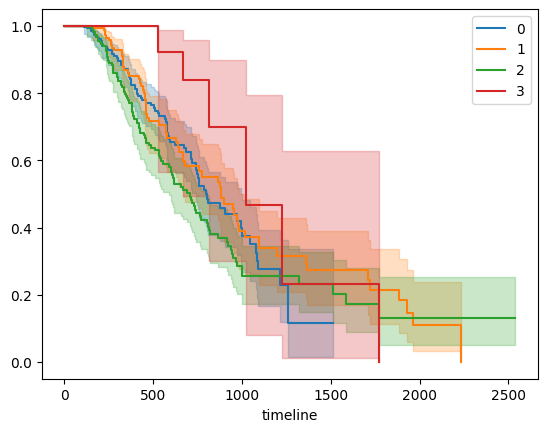

In [16]:
groups1 = dict(tuple(Lung_survival.groupby('cluster')))
groups2 = [groups1[i] for i in groups1]
groups_details(groups2, [0,1,2,3,4])

# Graph based survival analysis
- run PSG, SNF
- divide the SNF into three sub-networks
- run clustering on each
- report survival analysis for each

In [18]:
import networkx as nx

Lung_patients    = OS_Lung['vha_id']
Lung_cancer_type = OS_Lung['cancer_type']

G = nx.Graph()
for i, node in enumerate(Lung_patients):
    G.add_node(i, feature=Lung_cancer_type[i])

for i in range(len(Lung_patients)):
    for j in range(i+1, len(Lung_patients)):
        similarity = fused_network[i][j]
        G.add_edge(i,j, weight=similarity)

print('Number of patients = ', len(Lung_patients))
        
lung_NSCLC         = OS_Lung[OS_Lung['cancer_type'] == 'NSCLC']['vha_id']
lung_NSCLC_Surgery = OS_Lung[OS_Lung['cancer_type'] == 'NSCLC Surgery']['vha_id']
lung_SCLC          = OS_Lung[OS_Lung['cancer_type'] == 'SCLC']['vha_id']


NSCLC_edges         = [(u,v) for u,v in G.edges() if u in lung_NSCLC and v in lung_NSCLC]
NSCLC_Surgery_edges = [(u,v) for u,v in G.edges() if u in lung_NSCLC_Surgery and v in lung_NSCLC_Surgery]
SCLC_edges          = [(u,v) for u,v in G.edges() if u in lung_SCLC and v in lung_SCLC]

G1 = nx.Graph()
G1.add_edges_from(NSCLC_edges)

G2 = nx.Graph()
G2.add_edges_from(NSCLC_Surgery_edges)

G3 = nx.Graph()
G3.add_edges_from(SCLC_edges)

print(f'Nodes of G = {len(G)} \t Edges = {len(G.edges())}')
print(f'Nodes of G1 = {len(G1)} \t Edges = {len(G1.edges())}')
print(f'Nodes of G2 = {len(G2)} \t Edges = {len(G2.edges())}')
print(f'Nodes of G3 = {len(G3)} \t Edges = {len(G3.edges())}')

#spectral clustering needs fully connected network:
NSCLC_sim         = nx.to_numpy_array(G1)
NSCLC_Surgery_sim = nx.to_numpy_array(G2)
SCLC_sim          = nx.to_numpy_array(G3)

#                                     3-  Clustering

all_labels           = spectral_clustering(nx.to_numpy_array(G), n_clusters= nc)
NSCLC_labels         = spectral_clustering(NSCLC_sim, n_clusters= nc)
NSCLC_Surgery_labels = spectral_clustering(NSCLC_Surgery_sim, n_clusters= nc)
SCLC_labels          = spectral_clustering(SCLC_sim, n_clusters= nc)

Number of patients =  773
Nodes of G = 773 	 Edges = 298378
Nodes of G1 = 547 	 Edges = 149331
Nodes of G2 = 65 	 Edges = 2080
Nodes of G3 = 161 	 Edges = 12880


# SNF Survival analysis

Number of patients in cluser 0 = 240
Number of patients in cluser 1 = 200
Number of patients in cluser 2 = 300
Number of patients in cluser 3 = 33
1023.0
     3_lower_0.95  3_upper_0.95
0.5         666.0        1773.0
P-value (0,1) =  0.045629420476152226
P-value (0,2) =  0.08495163123666608
P-value (0,3) =  0.025740520299017435
P-value (1,2) =  0.4303760783083046
P-value (1,3) =  0.22041915400000148
P-value (2,3) =  0.04979819309316518


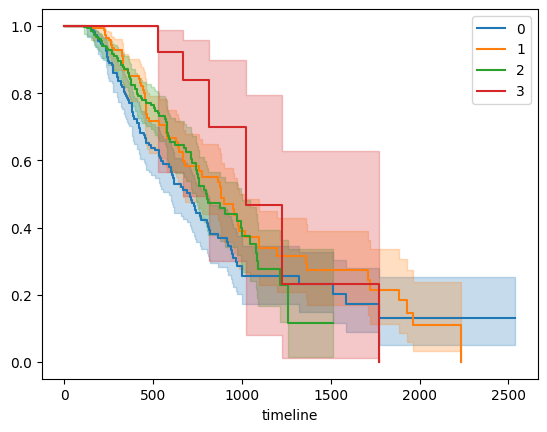

In [19]:
lung_All = {}
lung_All     = {'vha_id': Lung_patients[list(G.nodes())]    , 'cluster': list(all_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups,[i for i in range(nc)])


## NSCLC-graph survival analysis

Number of patients in cluser 0 = 14
Number of patients in cluser 1 = 7
Number of patients in cluser 2 = 501
Number of patients in cluser 3 = 25
598.0
     3_lower_0.95  3_upper_0.95
0.5         337.0         881.0
P-value (0,1) =  0.9261513448890616
P-value (0,2) =  0.8910220768475204
P-value (0,3) =  0.7027985594218678
P-value (1,2) =  0.6757308108675232
P-value (1,3) =  0.2788834161976973
P-value (2,3) =  0.06645732127497488


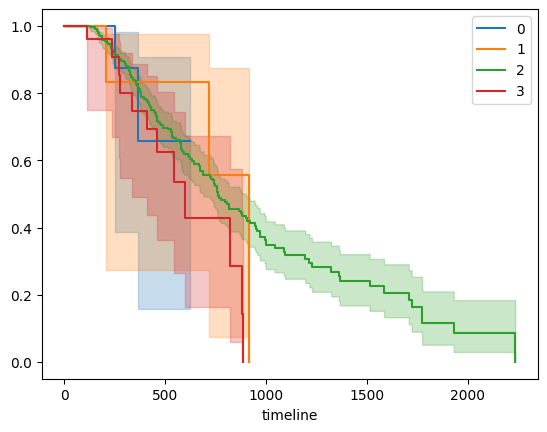

In [20]:
lung_All = {}
lung_All     = {'vha_id': Lung_patients[list(G1.nodes())]    , 'cluster': list(NSCLC_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups,[i for i in range(nc)])


## NSCLC_surgery Graph survival analysis

Number of patients in cluser 0 = 48
Number of patients in cluser 1 = 11
Number of patients in cluser 2 = 5
Number of patients in cluser 3 = 1
inf
     3_lower_0.95  3_upper_0.95
0.5           inf           inf
P-value (0,1) =  0.9628798546956342
P-value (0,2) =  0.28359526040279703
P-value (0,3) =  0.8758960579229415
P-value (1,2) =  0.33473598338039284
P-value (1,3) =  0.6288342916290457
P-value (2,3) =  1.0


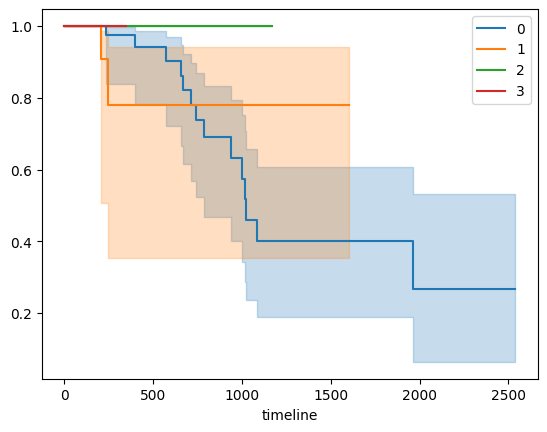

In [21]:
lung_All = {}
lung_All     = {'vha_id': Lung_patients[list(G2.nodes())]    , 'cluster': list(NSCLC_Surgery_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups, [i for i in range(nc)])


## SCLC Graph survival analysis

Number of patients in cluser 0 = 100
Number of patients in cluser 1 = 58
Number of patients in cluser 2 = 2
Number of patients in cluser 3 = 1
inf
     3_lower_0.95  3_upper_0.95
0.5           inf           inf
P-value (0,1) =  0.14480425367779684
P-value (0,2) =  0.8241104900735563
P-value (0,3) =  0.8428507357318858
P-value (1,2) =  0.5623809929771157
P-value (1,3) =  1.0
P-value (2,3) =  1.0


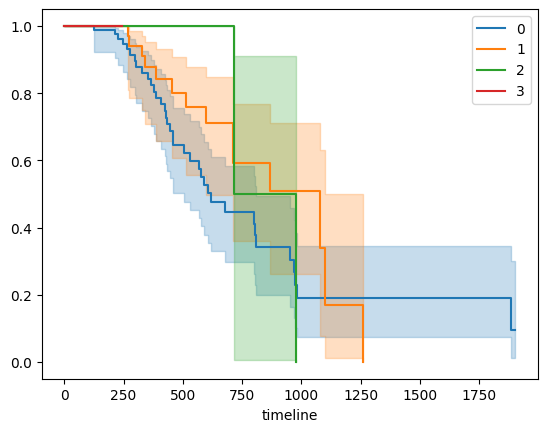

In [22]:
lung_All = {}
lung_All     = {'vha_id': Lung_patients[list(G3.nodes())]    , 'cluster': list(SCLC_labels)}
df_lung = pd.DataFrame(lung_All)

Lung_survival = pd.merge(df_lung, survival, on='vha_id')

groups = dict(tuple(Lung_survival.groupby('cluster')))
groups = [groups[i] for i in groups]
groups_details(groups, [i for i in range(nc)])
